## Классификация

In [2]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, ParameterGrid, KFold
from sklearn import metrics
import sklearn

### Датасет
В работе используется датасет `iris` из `sklearn`
Данный датасет содержит 3 класса и 4 параметра.


In [3]:
iris = load_iris()
type(iris)
print(iris.feature_names)
print(iris.target_names)


['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']


### Визуализация датасета
Визуализация по длине и ширине чашелистика.

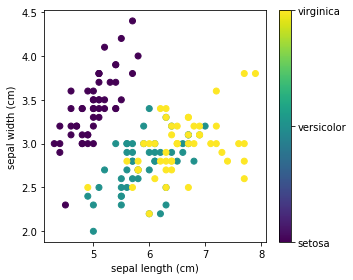

In [4]:
def plot_iris(x_index, y_index):
    # this formatter will label the colorbar with the correct target names
    formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])

    plt.figure(figsize=(5, 4))
    plt.scatter(iris.data[:, x_index], iris.data[:, y_index], c=iris.target)
    plt.colorbar(ticks=[0, 1, 2], format=formatter)
    plt.xlabel(iris.feature_names[x_index])
    plt.ylabel(iris.feature_names[y_index])

    plt.tight_layout()
    plt.show()


plot_iris(0, 1)

Визуализация по длине и ширине лепестка.

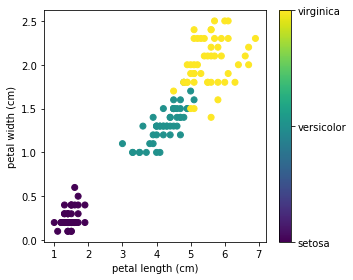

In [5]:
plot_iris(2, 3)

In [6]:
X = iris.data
y = iris.target

### `sklearn_test_run`
Данная функция запускает классификатор из sklearn и строит графики аккуратности, точности, полноты, F-меры.
Для `DecisionTreeClassifier` также строит дерево классификации.

Входные данные:
* `model-class` - классификатор,
* `X_lr` - параметры,
* `y_lr` - классы
* `parameters` - параметры классификатора
* `splits` - итератор с процентами разделения датасета на обучающую и тестовую выборки
* `repeats` - количество повторов.

Выходные данные:
Список вида вида (parameters, (accuracies, recalls, precisions, F1))


In [20]:
def sklearn_test_run(model_class, X_lr, y_lr, parameters={}, splits=np.arange(0.1, 0.4, 0.05), repeats=10):
    output = []
    plot = True
    combinations = ParameterGrid(parameters)
    rows = (len(combinations) + 1) // 2
    cols = 2 if len(combinations) > 1 else 1

    fig, axes = plt.subplots(nrows = rows, ncols = cols, figsize=(cols*6, rows*5))
    for idx, combination in enumerate(combinations):
        accuracies = defaultdict(int)
        recalls = defaultdict(int)
        precisions = defaultdict(int)
        f1s = defaultdict(int)
        for i in range(repeats):
            for split in splits:
                X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=split, stratify=y)
                model = model_class(**combination)
                model.fit(X_train, y_train)
                if plot and model_class.__name__ == "DecisionTreeClassifier":
                    plt.figure(dpi=400)
                    out = sklearn.tree.plot_tree(model, class_names=iris.target_names, feature_names=iris.feature_names,
                                                 filled=True)
                    plot = False
                predicted = model.predict(X_test)
                expected = y_test
                average = 'weighted'
                accuracies[split] += metrics.accuracy_score(expected, predicted)
                recalls[split] += metrics.recall_score(expected, predicted, average=average)
                precisions[split] += metrics.precision_score(expected, predicted, average=average)
                f1s[split] += metrics.f1_score(expected, predicted, average=average)

        accuracies = {k: v / repeats for k, v in accuracies.items()}
        recalls = {k: v / repeats for k, v in recalls.items()}
        precisions = {k: v / repeats for k, v in precisions.items()}
        f1s = {k: v / repeats for k, v in f1s.items()}
        if cols == 1:
            ax = axes
        elif rows == 1:
            ax = axes[idx % 2]
        else:
            ax = axes[idx // 2, idx % 2]

        ax.plot(*zip(*accuracies.items()), label='Accuracy')
        ax.plot(*zip(*recalls.items()), label='Recall')
        ax.plot(*zip(*precisions.items()), label='Precision')
        ax.plot(*zip(*f1s.items()), label='F1')
        ax.set_title(model_class.__name__ + ': ' + str(combination))
        ax.set_xlabel("Split")
        ax.set_ylim(0.9, 1)
        ax.legend()
        output.append((combination, (accuracies, recalls, precisions, f1s)))
    return output

### Байесовский классификатор

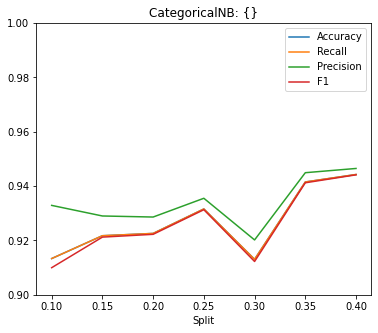

In [22]:
from sklearn.naive_bayes import CategoricalNB

bayes_outs = sklearn_test_run(CategoricalNB, X, y, repeats=10)

### Дерево решений

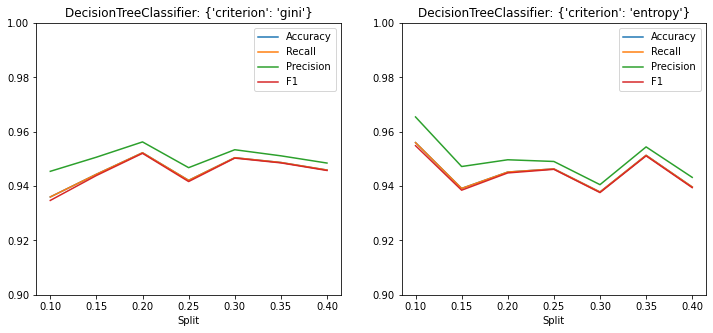

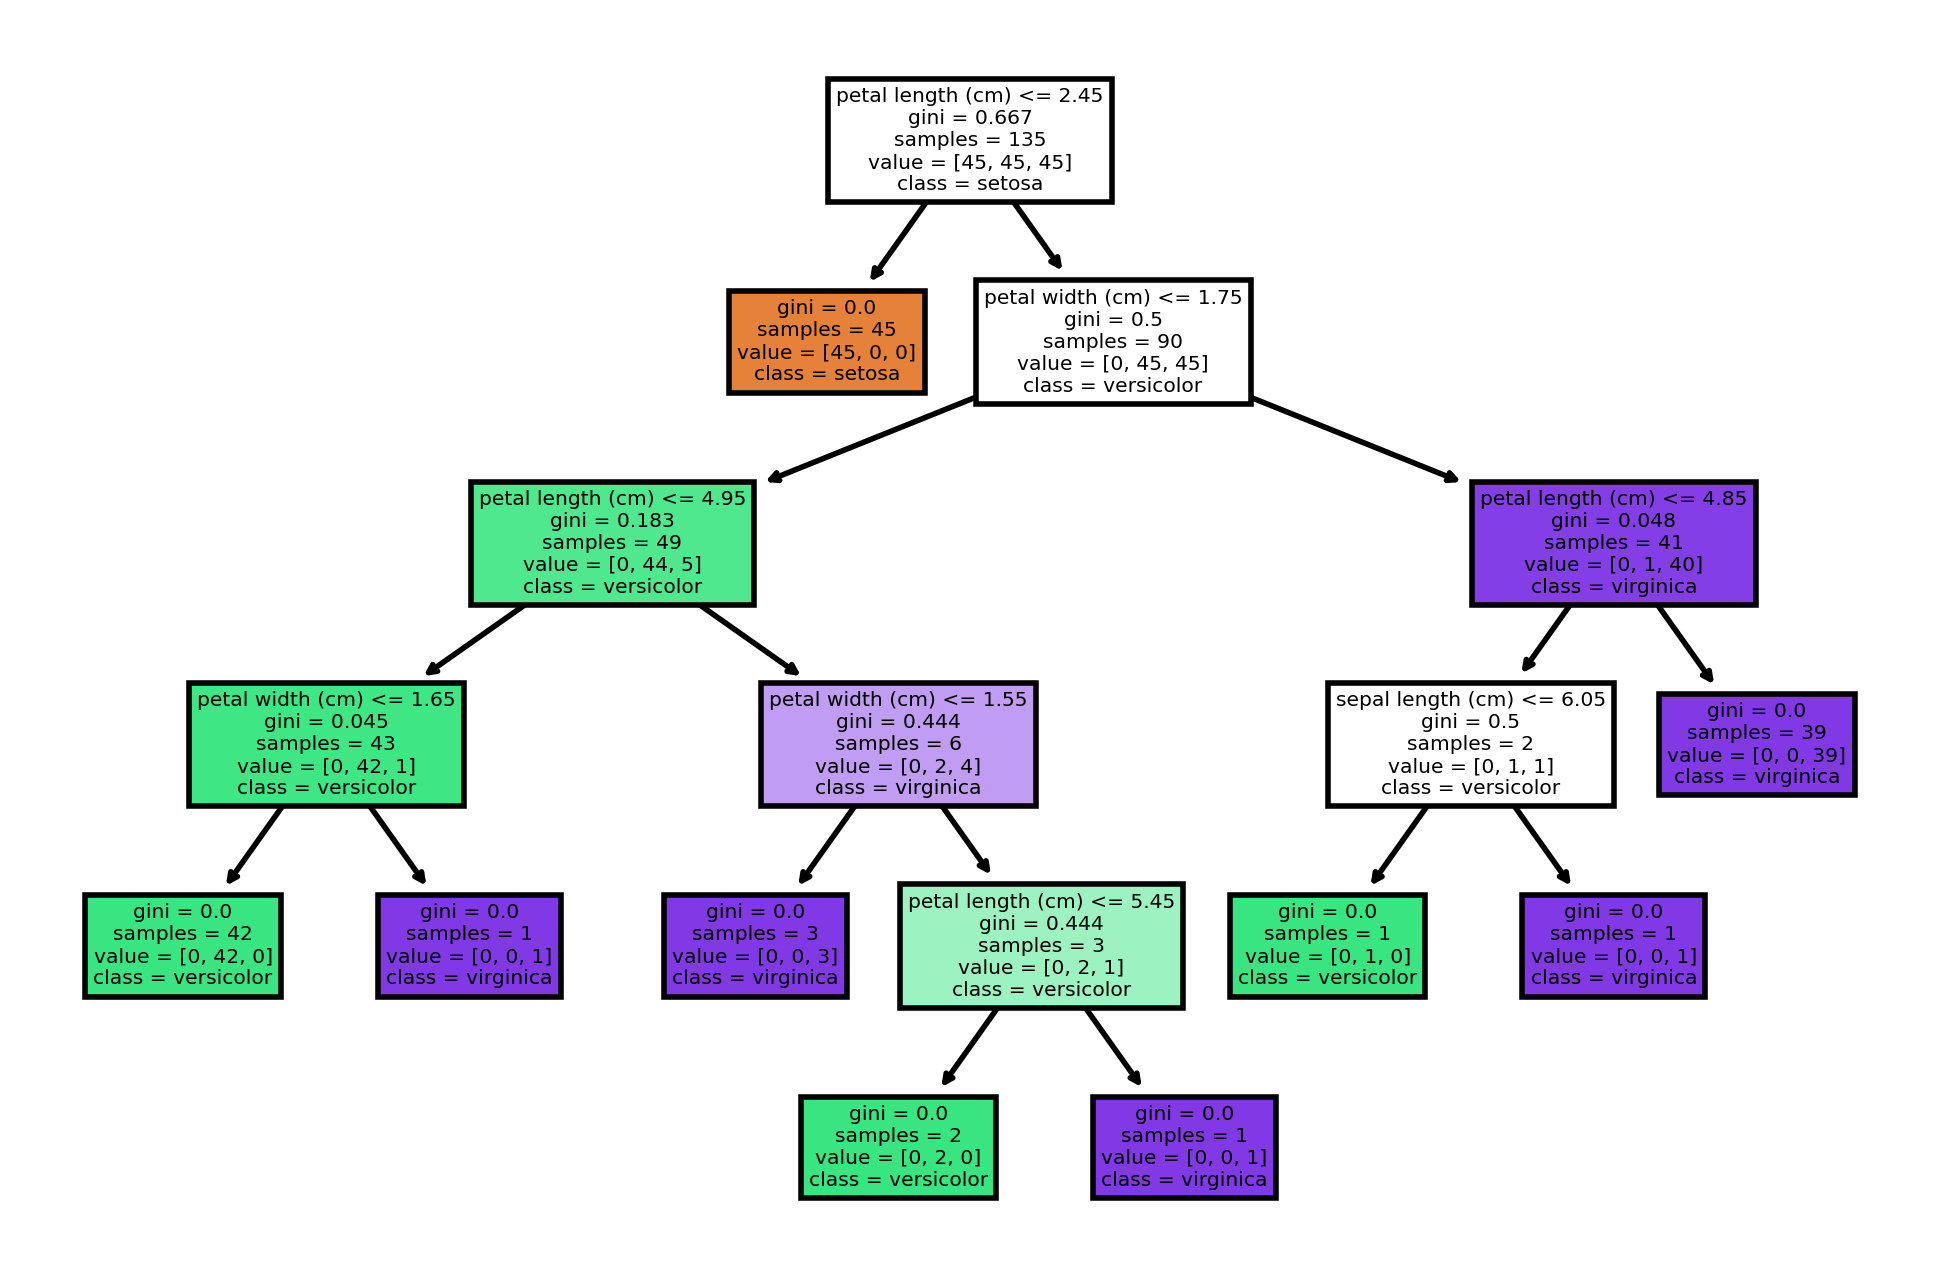

In [23]:
from sklearn.tree import DecisionTreeClassifier

tree_outs = sklearn_test_run(DecisionTreeClassifier, X, y, parameters={'criterion': ['gini', 'entropy']}, repeats=50)

### Бэггинг

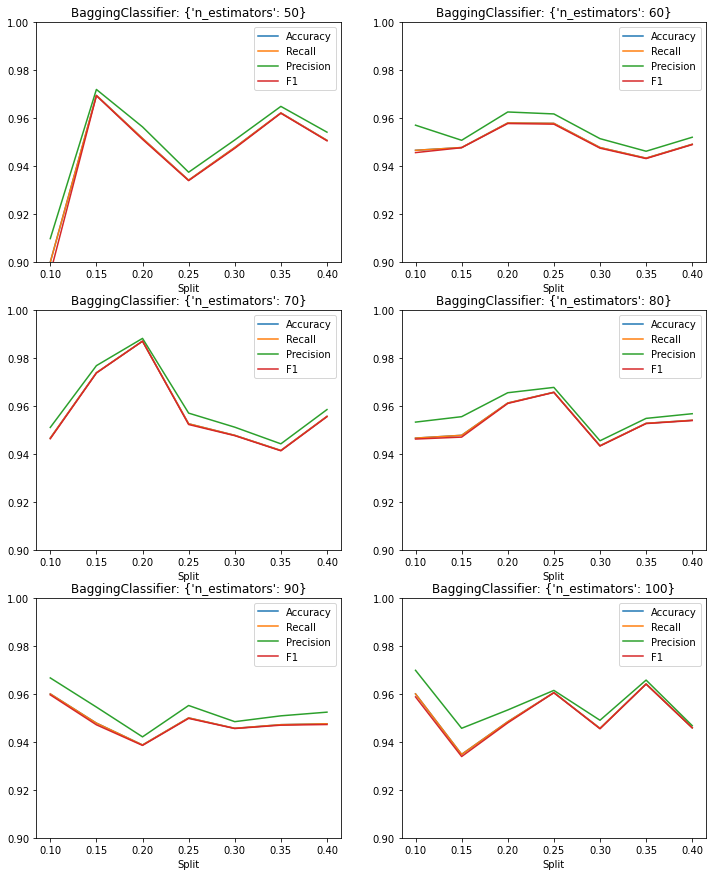

In [24]:
from sklearn.ensemble import BaggingClassifier

bagging_outs = sklearn_test_run(BaggingClassifier, X, y, parameters={'n_estimators': np.arange(50, 101, 10)})

### Случайный лес

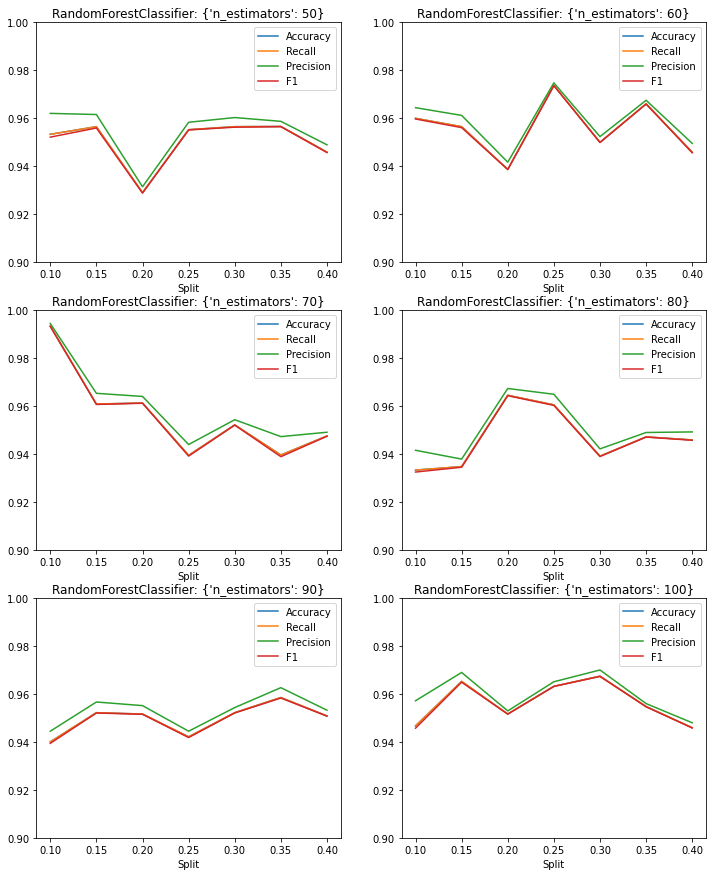

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_outs = sklearn_test_run(RandomForestClassifier, X, y, parameters={'n_estimators': np.arange(50, 101, 10)})

### Gradient Boosting

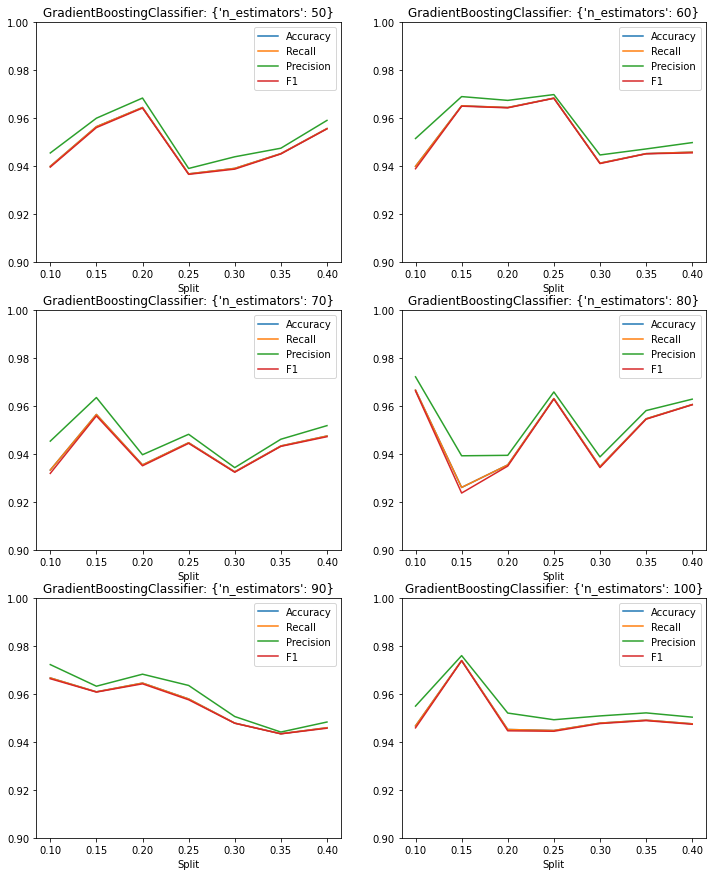

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_outs = sklearn_test_run(GradientBoostingClassifier, X, y, parameters={'n_estimators': np.arange(50, 101, 10)})


### Сравнение методов

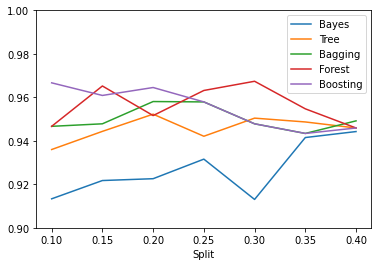

In [31]:
bayes = bayes_outs[0][1][0]
tree = tree_outs[0][1][0]  # Gini
bagging = bagging_outs[1][1][0]  # 60 estimators
forest = forest_outs[5][1][0]  # 100 trees
boosting = gradient_outs[4][1][0]  # 90 trees

plt.plot(*zip(*bayes.items()), label='Bayes')
plt.plot(*zip(*tree.items()), label='Tree')
plt.plot(*zip(*bagging.items()), label='Bagging')
plt.plot(*zip(*forest.items()), label='Forest')
plt.plot(*zip(*boosting.items()), label='Boosting')
plt.xlabel("Split")
plt.ylim(0.9, 1)
plt.legend()